In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

Using TensorFlow backend.


#### carregar a base de dados

In [2]:
(previsores_treinamento, _), (previsores_teste, _) = mnist.load_data()
previsores_treinamento = previsores_treinamento.reshape((len(previsores_treinamento), 28, 28, 1))
previsores_teste = previsores_teste.reshape((len(previsores_teste), 28, 28, 1))

#### Normalização dos dados

In [3]:
previsores_treinamento = previsores_treinamento.astype('float32') / 255
previsores_teste = previsores_teste.astype('float32') / 255

#### Estrutura do modelo

In [4]:
autoencoder = Sequential()

# Encoder
autoencoder.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape=(28,28,1)))
autoencoder.add(MaxPooling2D(pool_size = (2,2)))

autoencoder.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size = (2,2), padding='same'))

# 4, 4, 8
autoencoder.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', padding='same', strides = (2,2)))

autoencoder.add(Flatten())

autoencoder.add(Reshape((4,4,8)))

# Decoder
autoencoder.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', padding='same'))
autoencoder.add(UpSampling2D(size = (2,2)))
autoencoder.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu', padding='same'))
autoencoder.add(UpSampling2D(size = (2,2)))
autoencoder.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu'))
autoencoder.add(UpSampling2D(size = (2,2)))
autoencoder.add(Conv2D(filters = 1, kernel_size = (3,3), activation = 'sigmoid', padding='same'))

In [5]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)          

#### Treinamento

In [6]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
autoencoder.fit(previsores_treinamento, previsores_treinamento,
                epochs = 10, batch_size = 256, 
                validation_data = (previsores_teste, previsores_teste))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 77s 1ms/step - loss: 0.2853 - accuracy: 0.7959 - val_loss: 0.1640 - val_accuracy: 0.7977
Epoch 2/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1497 - accuracy: 0.8010 - val_loss: 0.1363 - val_accuracy: 0.8052
Epoch 3/10
60000/60000 [==============================] - 75s 1ms/step - loss: 0.1299 - accuracy: 0.8063 - val_loss: 0.1231 - val_accuracy: 0.8068
Epoch 4/10
60000/60000 [==============================] - 88s 1ms/step - loss: 0.1207 - accuracy: 0.8084 - val_loss: 0.1166 - val_accuracy: 0.8086
Epoch 5/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.1157 - accuracy: 0.8094 - val_loss: 0.1135 - val_accuracy: 0.8079
Epoch 6/10
60000/60000 [==============================] - 78s 1ms/step - loss: 0.1126 - accuracy: 0.8100 - val_loss: 0.1099 - val_accuracy: 0.8093
Epoch 7/10
60000/60000 [==============================] - 72s 1ms/st

#### Encoder e Decoder

In [7]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('flatten_1').output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0   

In [8]:
imagens_codificadas = encoder.predict(previsores_teste)
imagens_decodificadas = autoencoder.predict(previsores_teste)

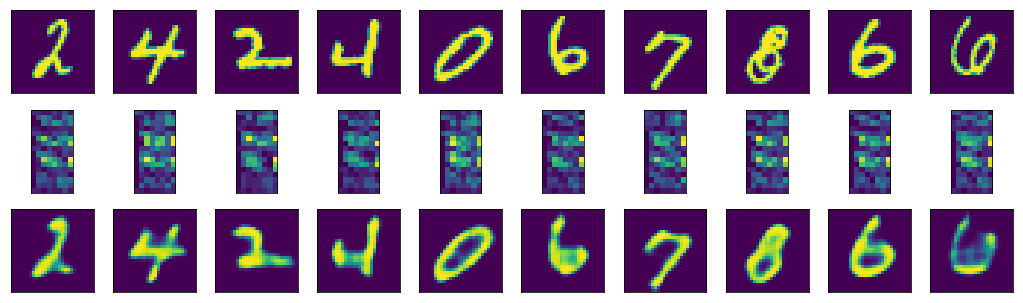

In [9]:
numero_imagens = 10
imagens_teste = np.random.randint(previsores_teste.shape[0], size = numero_imagens)
plt.figure(figsize=(18,18))
for i, indice_imagem in enumerate(imagens_teste):
    # imagem original
    eixo = plt.subplot(10,10,i + 1)
    plt.imshow(previsores_teste[indice_imagem].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
    
    # imagem codificada
    eixo = plt.subplot(10,10,i + 1 + numero_imagens)
    plt.imshow(imagens_codificadas[indice_imagem].reshape(16,8))
    plt.xticks(())
    plt.yticks(())
    
     # imagem reconstruída
    eixo = plt.subplot(10,10,i + 1 + numero_imagens * 2)
    plt.imshow(imagens_decodificadas[indice_imagem].reshape(28,28))
    plt.xticks(())
    plt.yticks(())